## Biodiversity in National Parks

This is a project launched at Codecademy and it is a part of Data Scientist Career Path. More information [here](https://www.codecademy.com/learn/paths/data-science)

# Introduction -  Biodiversity in National Parks Portfolio Project

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations.

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.


**Note:** The data for this project is *inspired* by real data, but is mostly fictional.

## Project Scope

It's beneficial to create a project scope whenever a new project is being started. Four sections were created below to help guide the project's process and progress. The first section is the project goals, this section will define the high-level objectives and set the intentions for this project. The next section is the data, luckily in this project, data is already provided but still needs to be checked if project goals can be met with the available data. Thirdly, the analysis will have to be thought through, which include the methods and questions that are aligned with the project goals. Lastly, evaluation will help us build conclusions and findings from our analysis.

#### Goals

- How many categories are included in this dataset?
- Do we have a lot of species or just a few?
- Wich park are available?
- How looks the percentage distribution of each species category in National Parks?
- Which endangered animals are observed frequently?
- Which animals are the most and the least observed species in each park?
- Which categories (Bird, Mammal, etc.) have the highest chance to become at risk an need attention?
- Sparrow and hawks are observed frequently and they belong to the same category (birds): is the relationship between observations of these species and their risk of extinction statistically significant?
- Which park has more observations of endangered sparrows and hawks?

#### Data 

- I will use the `observations.csv` and `species_info.csv` files supplied from Codecademy

#### Analysis

In this section, descriptive statistics and data visualization techniques will be employed to understand the data better. Statistical inference will also be used to test if the observed values are statistically significant. 

#### Evaluation

Lastly, it's a good idea to revisit the goals and check if the output of the analysis corresponds to the questions first set to be answered (in the goals section). This section will also reflect on what has been learned through the process, and if any of the questions were unable to be answered. This could also include limitations or if any of the analysis could have been done using different methodologies.

## Import Python Modules

First import the preliminary modules that will be used in this project:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats import chi2_contingency
%matplotlib inline

## Load the Data

To analyze the status of conservation of species and their observations in national parks, load the datasets into DataFrames. Once loaded as DataFrames the data can be explored and visualized with Python.

In [2]:
# import first csv file 
s_info_df = pd.read_csv('species_info.csv')
display(s_info_df.head().style.set_caption('Infos on Species'))

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,nan
1,Mammal,Bos bison,"American Bison, Bison",nan
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Domesticated Cattle",nan
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",nan
4,Mammal,Cervus elaphus,Wapiti Or Elk,nan


In [3]:
# import second csv file
obs_df = pd.read_csv('observations.csv')
display(obs_df.head().style.set_caption('Observations in National Parks'))

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Exploratory Data Analysis

First I will remove string 'National Park' from park_name (smallest labels on graphs)

In [4]:
obs_df['park_name'] = obs_df['park_name'].str.replace('National Park', '')
display(obs_df.head().style.set_caption('Observations in National Parks'))

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains,68
1,Neovison vison,Great Smoky Mountains,77
2,Prunus subcordata,Yosemite,138
3,Abutilon theophrasti,Bryce,84
4,Githopsis specularioides,Great Smoky Mountains,85


Find how many rows and columns (respectively) we have in DataFrame spieces and observations.

In [5]:
print(f"spieces shape: {s_info_df.shape}")
print(f"observations shape: {obs_df.shape}")

spieces shape: (5824, 4)
observations shape: (23296, 3)


Find out how many species are in DataFrame `s_info_df` and how many different category exists.

In [6]:
print(f"spieces number: {s_info_df.scientific_name.nunique()}")

spieces number: 5541


In [7]:
print(f"spieces number: {s_info_df.category.nunique()}")
print(f"spieces categories: {s_info_df.category.unique()}")

spieces number: 7
spieces categories: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


Find out how many different National Parks are in DataFrame `obs_df` 

In [8]:
print(f"Numbers of different National Parks: {obs_df.park_name.nunique()}")
print(f"Different National Parks: {obs_df.park_name.unique()}")

Numbers of different National Parks: 4
Different National Parks: ['Great Smoky Mountains ' 'Yosemite ' 'Bryce ' 'Yellowstone ']


In [9]:
print(f"Total number of observations: {obs_df.observations.sum()}")

Total number of observations: 3314739


In [10]:
print(f"Conversation status unique values: {s_info_df.conservation_status.unique()}")

Conversation status unique values: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


There are 4 unique value in column **conservation_status:** `Species of Concern`, `Endangered`, `Threatened`, `In Recovery` and `NaN` value. 

Let's change `NaN` values to `Low Risk`

In [11]:
s_info_df.conservation_status[s_info_df.conservation_status.isna()] = 'Low Risk'
s_info_df.conservation_status = pd.Categorical(s_info_df.conservation_status,
                                               categories = ['Low Risk', 'Species of Concern', 'In Recovery', 'Threatened',
                                                             'Endangered'], ordered = True)

**Note:** I grouped conservation status due to information found on this [page](https://www.usgs.gov/faqs/what-are-differences-between-endangered-threatened-imperiled-and-risk-species?qt-news_science_products=0#qt-news_science_products)

In [12]:
display(pd.DataFrame({'conservation_status':s_info_df.conservation_status.unique()}))

,conservation_status
0,Low Risk
1,Species of Concern
2,Endangered
3,Threatened
4,In Recovery


**Summary:** Now I know some basic informations about those two dataframes. DataFrame `s_info_df` have 5824 rows and 4 columns and ob DataFrame `obs_df` have 23296 rows and 3 columns. There are 5541 different species divided by 7 categories: 
1. Mammal
1. Bird
1. Reptile
1. Amphibian
1. Fish
1. Vascular Plant
1. Nonvascular Plant

There are 4 different National Park in our observations file:
1. Great Smoky Mountains National Park
1. Yosemite National Park
1. Bryce National Park
1. Yellowstone National Park

The total number of observations in the parks are 3 314 739 which is quite a lot!

#### Connecting the Data Frames into one DataFrame named join_df

By joining `s_info_df` and `obs_df` together in a single dataframe `(join_df)` we can better investigate some connections. However it is necessary that the s_info_df has unique values for the key we will use for the merging process. In our case the index used for merge is the `scientific_name` column: one species can be only in one state (endangered, thretened, etc.) at a given time.

A quick check for duplicates is required.

In [13]:
s_dupli = s_info_df[s_info_df.scientific_name.duplicated(keep=False)]
print(f'Duplicates: {len(s_dupli)}')

Duplicates: 557


It make sense to keep only the worst record among the duplicates. For example, if a species shows both _threatened_ and _endangered_ only _endangered_ is kept, as this should give us the worst scenario in terms of risk. We can drop duplicates from s_info_df and keep only the first item.

In [14]:
# Canis lupis example before removing duplicates
canis_l_b = s_info_df[s_info_df.scientific_name.str.contains('Canis lupus')].reset_index(drop=True)
canis_l_b = canis_l_b.style.set_caption('Canis Lupus duplicates before removal')
display(canis_l_b)

,category,scientific_name,common_names,conservation_status
0,Mammal,Canis lupus,Gray Wolf,Endangered
1,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
2,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


In [15]:
# Drop duplicates
s_info_df.drop_duplicates(inplace=True, subset='scientific_name', keep='first')
s_info_df.reset_index(drop=True, inplace=True)

Then we update the relevant records with the worst status available among the duplicate.

In [16]:
# Worst cases
worst_cases = s_dupli.groupby('scientific_name').conservation_status.max()

# Update the status for each duplicate that we kept
for species, worst_risk in worst_cases.iteritems():
    s_info_df.conservation_status[s_info_df.scientific_name == species] = worst_risk
    

# Canis lupis example after dropping duplicates
canis_l_a = s_info_df[s_info_df.scientific_name.str.contains('Canis lupus')].reset_index(drop=True)
canis_l_a = canis_l_a.style.set_caption('Canis Lupus duplicates after removal')
display(canis_l_a)

,category,scientific_name,common_names,conservation_status
0,Mammal,Canis lupus,Gray Wolf,Endangered


Finally we have the call to merge.

In [17]:
# join dataframes
join_df = s_info_df.merge(obs_df, on='scientific_name', how='outer')
display(join_df.head().style
       .set_caption('Join process result'))

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Bryce,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yellowstone,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Great Smoky Mountains,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yosemite,117
4,Mammal,Bos bison,"American Bison, Bison",Low Risk,Yosemite,128


If the merge was done correctly we should end with a dataframe that is as long as the observation dataframe.

In [18]:
print(f'Length of s_info_df: \t{len(s_info_df)}')
print(f'Length of obs_df: \t{len(obs_df)}')
print(f'Length of join_df: \t{len(join_df)}')

Length of s_info_df: 	5541
Length of obs_df: 	23296
Length of join_df: 	23296


## Analysis

#### Categories - per number of observations

A simple bar graph describing the number of observations per category will show which categories exist in our dataset. In addition we will get an idea of the most frequent ones.

In [19]:
# first create dataframe contains category and observations
obs_and_cat_df = join_df[['category', 'observations']].groupby('category').sum().sort_values('observations', ascending=False).reset_index()
display(obs_and_cat_df)

,category,observations
0,Vascular Plant,2555090
1,Bird,292833
2,Nonvascular Plant,190653
3,Mammal,116696
4,Fish,70818
5,Reptile,44678
6,Amphibian,43971


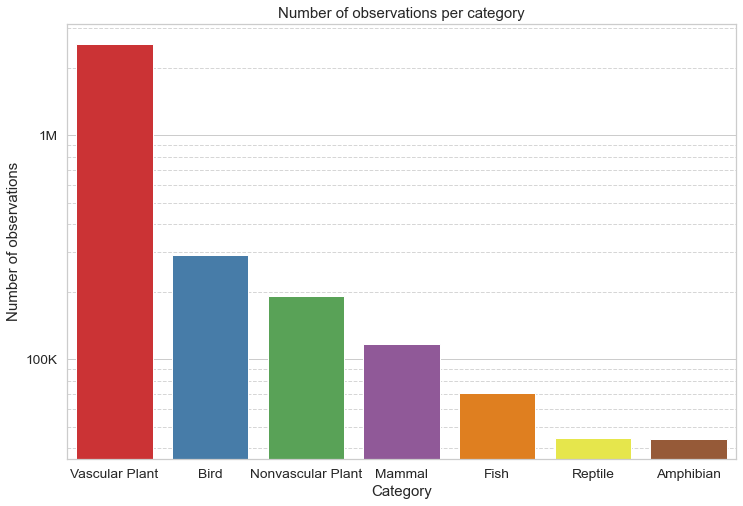

In [20]:
sns.set_style('whitegrid')
sns.set_palette('Set1')
sns.set_context(context='notebook', font_scale=1.25)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=obs_and_cat_df['category'], y=obs_and_cat_df['observations'])
plt.xlabel('Category')
plt.ylabel('Number of observations')
plt.title('Number of observations per category')
# y axis as log 
plt.yscale('log')
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
ax.set_yticklabels(('0', '0', '100K', '1M'))

plt.show()

**Summary:** As we can see the most observed category in our National Parks are Vascular Plant. The first place in number of observations for animals belonged  to Birds. 

####  Categories - per conservations_status

In [21]:
# first create dataframe contains category and their conservation_status
cat_and_con_df = join_df.groupby(['category', 'conservation_status']).scientific_name.count().reset_index()
cat_and_con_df.rename(columns={'scientific_name':'spieces_counts'}, inplace=True)
cat_and_con_df

,category,conservation_status,spieces_counts
0,Amphibian,Low Risk,292
1,Amphibian,Species of Concern,16
2,Amphibian,In Recovery,0
3,Amphibian,Threatened,8
4,Amphibian,Endangered,4
5,Bird,Low Risk,1768
6,Bird,Species of Concern,288
7,Bird,In Recovery,12
8,Bird,Threatened,0
9,Bird,Endangered,16


I want to show this data in a percentage on a bar plot so the following codes must be processed.

In [22]:
# count the unique values of 'category' column and put it to the list
cat = cat_and_con_df['category'].unique().tolist()

In [23]:
# loop through each  category and calculate percentage
spieces_counts = [] 
for aa in cat:
    x = cat_and_con_df[cat_and_con_df.category == aa].spieces_counts.sum()
    y = (cat_and_con_df[cat_and_con_df.category == aa].spieces_counts * 100) / x
    spieces_counts.append(y)
    print( aa, y.sum()) # print result to check if correct calculation
    
spieces_counts = np.concatenate(spieces_counts)    

Amphibian 100.0
Bird 99.99999999999999
Fish 100.0
Mammal 100.0
Nonvascular Plant 100.0
Reptile 100.0
Vascular Plant 100.0


In [24]:
# add column percentage to DataFrame 
cat_and_con_df['percentage'] = spieces_counts
display(cat_and_con_df)

,category,conservation_status,spieces_counts,percentage
0,Amphibian,Low Risk,292,91.250000
1,Amphibian,Species of Concern,16,5.000000
2,Amphibian,In Recovery,0,0.000000
3,Amphibian,Threatened,8,2.500000
4,Amphibian,Endangered,4,1.250000
5,Bird,Low Risk,1768,84.836852
6,Bird,Species of Concern,288,13.819578
7,Bird,In Recovery,12,0.575816
8,Bird,Threatened,0,0.000000
9,Bird,Endangered,16,0.767754


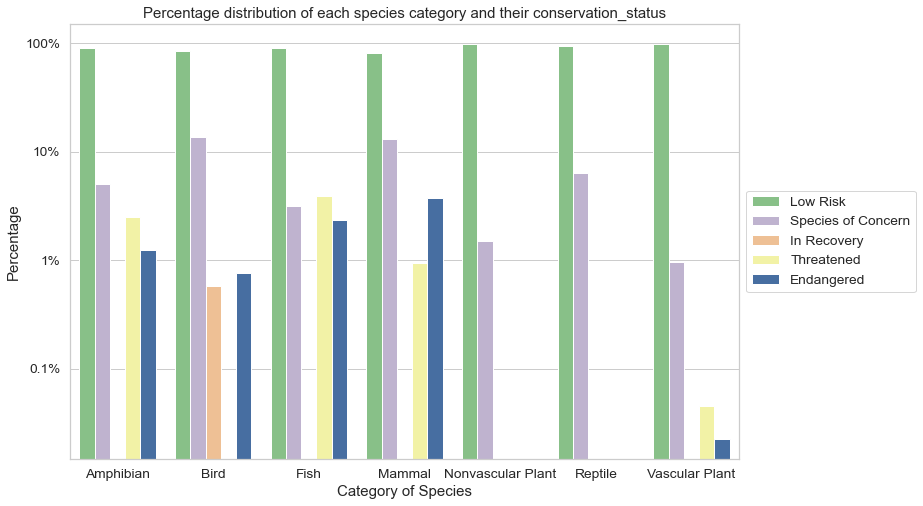

In [25]:
# create bar plot
sns.set_palette('Accent')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=cat_and_con_df['category'], y=cat_and_con_df['percentage'], hue=cat_and_con_df['conservation_status'])
plt.title('Percentage distribution of each species category and their conservation_status')
plt.yscale('log')
ax.set_yticklabels(('0', '0', '0.1%', '1%', '10%', '100%'))
plt.xlabel('Category of Species')
plt.ylabel('Percentage')
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

**Summary:** I used logarithmic scale on y axis to show better the results. As we can see `the most endangered species are:` Mammal, Fish, Amphibian and Bird. It is really comforting that in each category the massive amount - more than 90% are in Low Risk. 

#### Parks

What is a number of observations in each National Parks?

In [26]:
# first create dataframe contains info abount observations in each park
ob_by_park = join_df.groupby('park_name').observations.sum().reset_index()
display(ob_by_park)

,park_name,observations
0,Bryce,576025
1,Great Smoky Mountains,431820
2,Yellowstone,1443562
3,Yosemite,863332


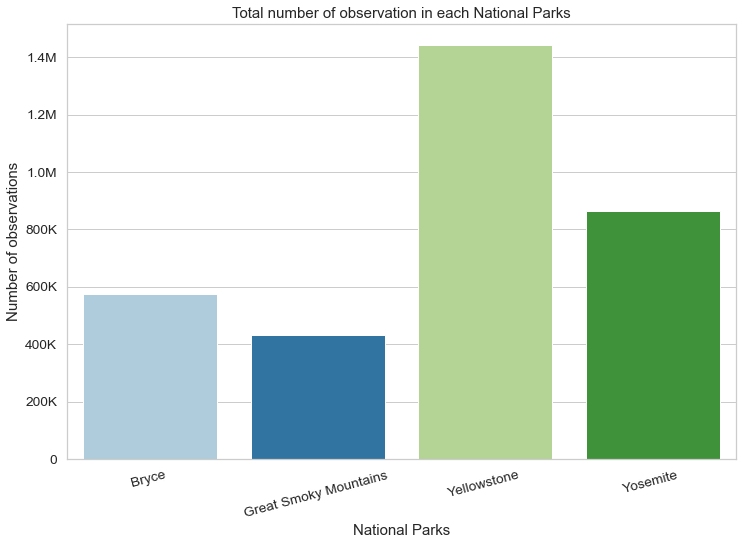

In [27]:
# bar plot for observations in each National Parks
sns.set_palette('Paired')
plt.figure(figsize=(12,8))
p = sns.barplot(data=ob_by_park, x='park_name', y='observations', estimator=sum)
plt.ylabel('Number of observations')
plt.xlabel('National Parks')
plt.title('Total number of observation in each National Parks')
plt.xticks(rotation=15)
p.set_yticklabels(['0', '200K', '400K', '600K', '800K', '1.0M', '1.2M', '1.4M'])
plt.show()

**Summary:** As we can see the Yellowstone has the largest number of observation - more than 1.4M.  Yosemite is on second place with 800K observations. Then is Bryce with almost 600K observations and in the end is Great Smoky Mountains with result a little more than 400K observations. 

How looks  the percentage distribution of each species category in National Parks?

In [28]:
# Create grouped frame with parks and observations
obs_and_park_df = join_df.pivot_table(index='park_name', columns='category', values='observations', aggfunc=sum)
# Convert value to percentage
obs_and_park_df = obs_and_park_df.apply(lambda x: x/x.sum()*100,  axis=1)
# Adjust row/column description
obs_and_park_df.rename_axis('Park name', inplace=True)
obs_and_park_df.rename_axis('Category', axis='columns', inplace=True)

display(obs_and_park_df.style
        .format("{:.1f}%")
        .set_caption('Observation percentages'))

Category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
Park name,,,,,,,
Bryce,1.3%,9.0%,2.2%,3.6%,5.7%,1.4%,76.9%
Great Smoky Mountains,1.3%,8.7%,2.1%,3.5%,5.8%,1.3%,77.3%
Yellowstone,1.3%,8.8%,2.1%,3.5%,5.8%,1.4%,77.1%
Yosemite,1.3%,8.8%,2.2%,3.5%,5.8%,1.3%,77.1%


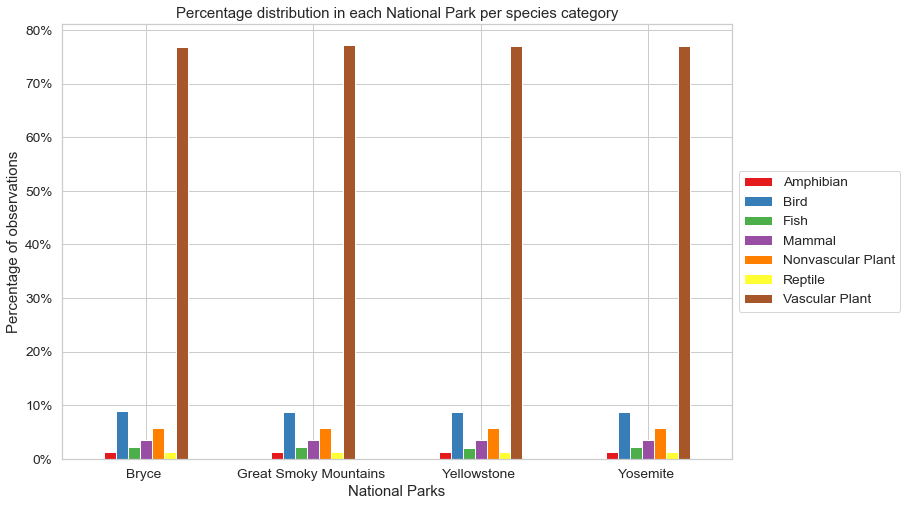

In [29]:
sns.set_palette('Set1')
a = obs_and_park_df.plot(kind='bar', stacked=False, figsize=[12, 8])
plt.xlabel('National Parks')
plt.ylabel('Percentage of observations')
plt.title('Percentage distribution in each National Park per species category')
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)
plt.xticks(rotation=0)
a.set_yticklabels(('0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'))
plt.show()

**Summary:** The table above and bar plot shows the percentage distribution of species category in each National Park. As we can noticed the numbers are almost the same for each park and it suggest that the data provided at the beginning are mostly fictioned.  

#### Frequent observations of endangered animals

We want to find frequently spotted endangered animals: we can look at the frequence of words in common_names column. Since we are interested in species at risk it is better to create two dedicated dataframes, `endangered_species` and `endangered_obs`, which exclude the 'Low Risk' label from species informations and observation statuses respectively. Repeated names belong to frequently observed animals.

In [30]:
# Create endangered dataframe for both s_info_df and join_df
endangered_species = s_info_df[~ s_info_df.conservation_status.isin(['Low Risk'])].copy()
endangered_obs = join_df[~ join_df.conservation_status.isin(['Low Risk'])].copy()

# Remove low risk from categories
endangered_species.conservation_status = endangered_species.conservation_status.cat.remove_unused_categories()
endangered_obs.conservation_status = endangered_obs.conservation_status.cat.remove_unused_categories()

# Crate a bag of words with all words from common names in observations
bag_words = endangered_obs.common_names.str.replace(',', '').str.split('\s')
# Create a list of words
names_words = []
for index, words in bag_words.iteritems():
    names_words.extend(words)
# Find values count
names_words = pd.Series(names_words, name='word_count')
word_count = names_words.value_counts().to_frame()
# Look at first 20
display(word_count[:20].style.set_caption('Frequent words - top 20'))

,word_count
Myotis,96
Bat,60
Brown,40
American,28
California,28
Northern,28
Mountain,28
Little,24
Warbler,16
Sparrow,16


Following endangered animals are easier to observe during a visit:
1. Bats
1. Warblers
1. Sparrows
1. Hawks
1. Snakes
1. Badgers
1. Wolves

_Which animals are the most and the least observed species in each park?_

To find answer to this question the following function I will write. It will find for each National Parks the minimum and maximum observations and the name of it.

In [31]:
def get_min_max_observations(dataF, what):
   df = pd.DataFrame() 
   for park in dataF.park_name.unique():
      data_by_park = dataF[ dataF.park_name == park ].reset_index(drop=True)
      if ( what == 'min'):
         df = df.append(data_by_park[ data_by_park.observations == data_by_park.observations.min() ] ).reset_index(drop=True)
      elif ( what == 'max' ):
         df = df.append(data_by_park[ data_by_park.observations == data_by_park.observations.max() ] ).reset_index(drop=True)
      else:
         print( 'Error, select min or max in what' )
         return None
   return(df.reset_index(drop=True))

In [32]:
get_min_max_observations(join_df, 'min')

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Corydalis aurea,"Golden Corydalis, Scrambled Eggs",Low Risk,Bryce,9
1,Bird,Grus americana,Whooping Crane,Endangered,Yellowstone,57
2,Vascular Plant,Collomia tinctoria,"Staining Collomia, Yellowstain Collomia",Low Risk,Great Smoky Mountains,10
3,Fish,Noturus baileyi,Smoky Madtom,Endangered,Yosemite,31


**Summary:** The least observed species for: 
1. Great Smoky Mountains National Park - Collomia tinctoria with 10 observations
1. Yosemite National Park - Noturus baileyi with 31 observations
1. Bryce National Park - Corydalis aurea with 9 observations
1. Yellowstone National Park - Grus americana with 57 observations

In [33]:
get_min_max_observations(join_df, 'max')

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Valerianella radiata,"Beaked Corn-Salad, Corn Salad",Low Risk,Bryce,176
1,Vascular Plant,Lycopodium tristachyum,"Deep-Root Clubmoss, Ground Cedar",Low Risk,Yellowstone,321
2,Vascular Plant,Sonchus asper ssp. asper,Spiny Sowthistle,Low Risk,Great Smoky Mountains,147
3,Vascular Plant,Ivesia shockleyi var. shockleyi,"Shockley's Ivesia, Sky Mousetail",Low Risk,Yosemite,223


**Summary:** **Summary:** The most observed species for: 
1. Great Smoky Mountains National Park - Sonchus asper ssp. asper with 147 observations
1. Yosemite National Park - Ivesia shockleyi var. shockleyi with 223 observations
1. Bryce National Park - Valerianella radiata with 176 observations
1. Yellowstone National Park - Lycopodium tristachyum with 321 observations

## Scope of Project

After completing the exploratory analysis, let's define the scope of the project. Based on what above we will investigate the following questions:

* Which categories (Bird, Mammal, etc.) have the highest chance to become at risk an need attention?
* Sparrow and hawks are observed frequently and they belong to the same category (birds): is the relationship between observations of these species and their risk of extinction statistically significant?
* Which park has more observations of endangered sparrows and hawks?

#### Species at risk

In [34]:
display(s_info_df.conservation_status.value_counts(dropna=False).to_frame())

,conservation_status
Low Risk,5362
Species of Concern,151
Endangered,15
Threatened,10
In Recovery,3


In [35]:
display(endangered_species.conservation_status.value_counts(dropna=False).to_frame())

,conservation_status
Species of Concern,151
Endangered,15
Threatened,10
In Recovery,3


The tables above shows the total number of conservation_status in our file. First one contain 'Low Risk' status in a table and it seems that a massive number of species are not at risk of endangered. The second table shows the same numbers but without 'Low Risk' conservation_status to better illustrate the number of conservation_status.

25 species are endangered (both Endangered and Threatened status). 3 are In Recovery and 151 species requires special attention due to the high risk of changing the status to Endangered or Threatened. 

To answer the question `Which categories (Bird, Mammal, etc.) have the highest chance to become at risk an need attention?`, the following countplot will bring the solution. 

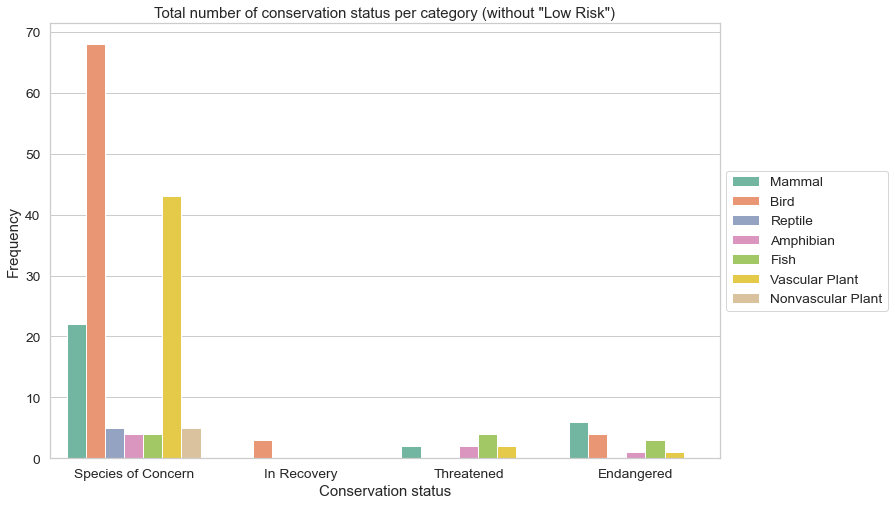

In [36]:
sns.set_palette('Set2')
plt.figure(figsize=(12, 8))
sns.countplot(data=endangered_species, x='conservation_status', hue='category')
plt.legend(loc=6, bbox_to_anchor=(1, 0.5), ncol=1)
plt.xlabel('Conservation status')
plt.ylabel('Frequency')
plt.title('Total number of conservation status per category (without "Low Risk")')
plt.show()

**Summary:** `Species of Concern` are those category which need special attention. This chart shows that **Birds, Vascular Plants and Mammals** are those species required special attention. 

#### Statistical significance of relationship between sparrows, hawks and conservation_status

Is there an association between bird type (hawk or sparrow) and its conservation status (low risk or species of concern in this case)? We will investigate this by using chi2_contingency test.

In [37]:
# Isolate Hawks and Sparrows observations (only common_names and conservation status are required)
SP_and_HW = join_df[(join_df.common_names.str.contains('Hawk|Sparrow')) 
                    & (join_df.category == 'Bird')].copy()
SP_and_HW = SP_and_HW[['park_name', 'common_names', 'conservation_status']].reset_index(drop=True)

# Add an Hawk or Sparrow identifier
SP_and_HW['hawk_or_sparrow'] = SP_and_HW.common_names.apply(lambda x: 'Hawk' if 'Hawk' in x else 'Sparrow')

# Display table
display(pd.concat([SP_and_HW.head(), SP_and_HW.tail()]).style
                  .set_caption('Sparrows and hawks observations (first and last rows)'))

,park_name,common_names,conservation_status,hawk_or_sparrow
0,Bryce,Cooper's Hawk,Species of Concern,Hawk
1,Yosemite,Cooper's Hawk,Species of Concern,Hawk
2,Yellowstone,Cooper's Hawk,Species of Concern,Hawk
3,Great Smoky Mountains,Cooper's Hawk,Species of Concern,Hawk
4,Yosemite,Sharp-Shinned Hawk,Species of Concern,Hawk
143,Yosemite,Gambel's White-Crowned Sparrow,Low Risk,Sparrow
144,Great Smoky Mountains,Mountain White-Crowned Sparrow,Low Risk,Sparrow
145,Yellowstone,Mountain White-Crowned Sparrow,Low Risk,Sparrow
146,Bryce,Mountain White-Crowned Sparrow,Low Risk,Sparrow
147,Yosemite,Mountain White-Crowned Sparrow,Low Risk,Sparrow


In [38]:
# Create a contingency table
contingency_SP_HW = pd.crosstab(SP_and_HW.conservation_status, SP_and_HW.hawk_or_sparrow)

# Adjust row/column description
contingency_SP_HW.rename_axis('Conservation Status', inplace=True)
contingency_SP_HW.rename_axis('Hawk/Sparrow', axis='columns', inplace=True)
display(contingency_SP_HW.style.set_caption('Contingency table'))

Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,16,100
Species of Concern,16,16


In [39]:
# Run chi2 test
alpha = 0.05
chi2, pval, _, expected_f = chi2_contingency(contingency_SP_HW)
result = ('significant' if pval < alpha else 'not significant')

print(f'chi2: {chi2:.2f}')
print(f'p-value: {pval:.3e}')
print(f'Test result: association between variables is {result}.')

chi2: 17.32
p-value: 3.151e-05
Test result: association between variables is significant.


According to [Scipy documentation:](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

_An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5._

Our minimum frequency in contingency_SP_HW is 16. What about expected ones?

In [40]:
expected_f_df = contingency_SP_HW.copy()
expected_f_df.iloc[:,:] = expected_f
display(expected_f_df.style
                     .format("{:.1f}")
                     .set_caption('Expected frequencies'))


Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,25.1,90.9
Species of Concern,6.9,25.1


Also expected frequencies are above 5, so we can deem the test as valid: **there is a relationship between the spotted bird type (hawk or sparrow) and its conservation status.**

This result means that it is improbable to draw an observations sample like the one we are looking at, from a population where no association exists between bird type (hawk / sparrow) and conservation status. When a bird is spotted, it is definitely easier to see a species of concern if that bird is an hawk.

Intuitively this make sense, as our database shows a proportion of species of concern which is higher for hawks than sparrows. In addition there are typically less hawks than sparrows in a stable ecosystem (as we would expect in a predator/prey relationship).

In [41]:
# Find info for hawks and sparrows species
SP_and_HW_info = s_info_df[(s_info_df.common_names.str.contains('Hawk|Sparrow')) 
                           & (s_info_df.category == 'Bird')].copy()

# Add an Hawk or Sparrow identifier
SP_and_HW_info['hawk_or_sparrow'] = SP_and_HW_info.common_names.apply(lambda x: 'Hawk' if 'Hawk' in x else 'Sparrow')

# Species of concern vs low risk
contingency_SP_HW_info = pd.crosstab(SP_and_HW_info.conservation_status, SP_and_HW_info.hawk_or_sparrow)

# Adjust row/column description
contingency_SP_HW_info.rename_axis('Conservation Status', inplace=True)
contingency_SP_HW_info.rename_axis('Hawk/Sparrow', axis='columns', inplace=True)
display(contingency_SP_HW_info.style.set_caption('Species vs conservation status'))

Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,4,24
Species of Concern,4,4


#### Which park has more observations of endangered sparrows and hawks?

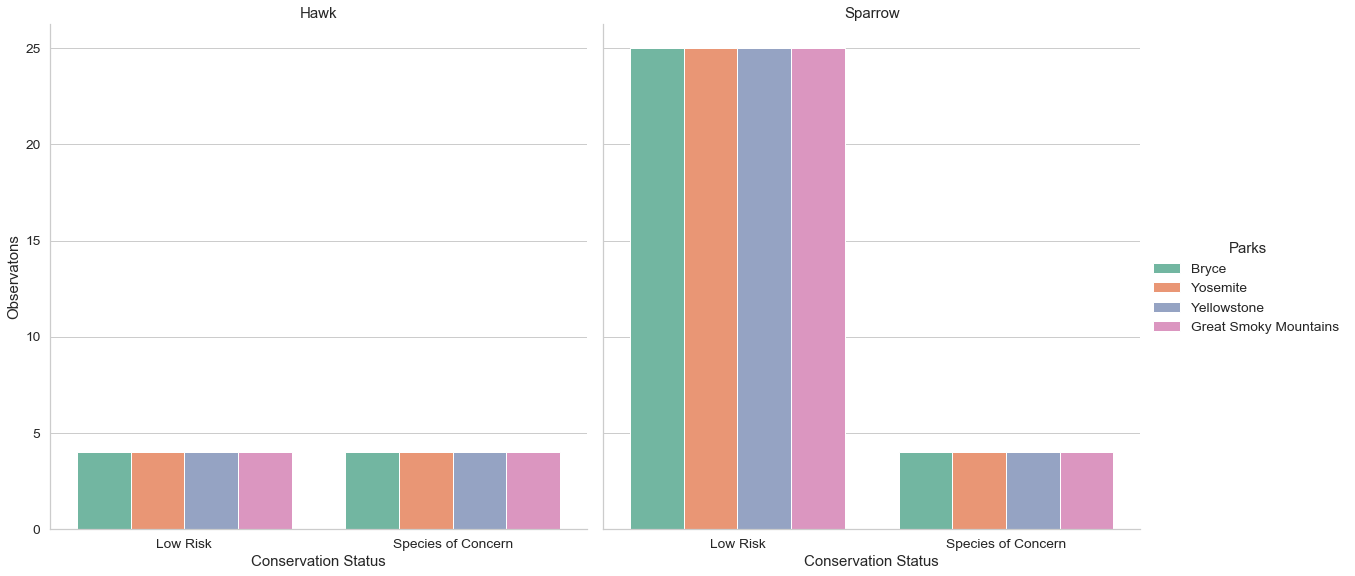

In [42]:
# Remove unused categories to obtain a better plot
SP_and_HW.conservation_status = SP_and_HW.conservation_status.cat.remove_unused_categories()

# Countplot
g = sns.catplot(x='conservation_status', col='hawk_or_sparrow',
                hue='park_name', data=SP_and_HW,
                kind="count", height=8,
                legend=True)

# Improve lables
for ax in g.axes[0,:]:
    ax.set_xlabel('Conservation Status')
g.axes[0,0].set_ylabel('Observatons')
g.axes[0,0].set_title('Hawk')
g.axes[0,1].set_title('Sparrow')
g._legend.set_title('Parks')
plt.show()

**Summary:** It seems that in each National Parks the chance to observed sparrows and hawks is the same and it is another prove that dataset are fictional. 

## Conclusions

I can finally review the questions from the goal section asked at the beginning:

- How many categories are included in this dataset?
    - There are 7  categories: Mammal, Bird, Reptile, Amphibian, Fish, Vascular Plant and Nonvascular Plant.

- Do we have a lot of species or just a few?
    - There are 5541 different species.

- Wich park are available?
    - There are 4 different National Park in our observations file: Great Smoky Mountains National Park, Yosemite National Park, Bryce National Park and Yellowstone National Park. 

- How looks the percentage distribution of each species category in National Parks?
    - More than 90% species category are in 'Low Risk' and from analysys I can conclude that Mammals, Fishes, Amphibians and Birds are the most endangered species from our dataset. 

- Which endangered animals are observed frequently?
    - The most frequently observed endangered animals from our dataset are: Bats, Warblers, Sparrows, Hawks, Snakes, Badgers and Wolves. 

- Which animals are the most and the least observed species in each park?
    - The least observed species for: 
        - Great Smoky Mountains National Park - Collomia tinctoria with 10 observations
        - Yosemite National Park - Noturus baileyi with 31 observations
        - Bryce National Park - Corydalis aurea with 9 observations
        - Yellowstone National Park - Grus americana with 57 observations
    - The most observed species for: 
        - Great Smoky Mountains National Park - Sonchus asper ssp. asper with 147 observations
        - Yosemite National Park - Ivesia shockleyi var. shockleyi with 223 observations
        - Bryce National Park - Valerianella radiata with 176 observations
        - Yellowstone National Park - Lycopodium tristachyum with 321 observations

- Which categories (Bird, Mammal, etc.) have the highest chance to become at risk an need attention?
    - Species of Concern are those category which need special attention. Birds, Vascular Plants and Mammals are those species required special attention.

- Sparrow and hawks are observed frequently and they belong to the same category (birds): is the relationship between observations of these species and their risk of extinction statistically significant?
    - After conducted chi2 test I can concluded that there is a relationship between the spotted bird type (hawk or sparrow) and its conservation status.

- Which park has more observations of endangered sparrows and hawks?
    - In each National Parks the chance to observe sparrows and hawks is the same. 

**Based on information provided by Codecademy in to datasets `observations.csv` and `species_info.csv`, and after conducting analysis I can tell with high probability that datasets are fictional.**